In [9]:
import inspect
import os
import sys
from typing import List, Dict, Tuple, Optional

from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.models.detection.roi_heads import RoIHeads, fastrcnn_loss
from torchvision.ops import MultiScaleRoIAlign

from common.data import DataGenerator

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import cv2
import mlflow
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn

from src.common.conics import plot_conics, conic_matrix, ellipse_axes, ellipse_angle, conic_center
from src.detection import create_detection_model
from src.detection.training import get_dataloaders

In [10]:
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("crater-detection")

In [11]:
dataset_path = "../data/dataset_2c6e817a-238f-4872-a17a-5896686b837a.h5"
batch_size = 10
num_workers = 4

train_loader, validation_loader, test_loader = get_dataloaders(dataset_path, batch_size, num_workers)

In [12]:
device = torch.device('cpu')
model = create_detection_model()
model.to(device)

checkpoint = mlflow.pytorch.load_state_dict(r'../artifacts/1/fb52f4caddb7419bb2ac35a2cd1cbbe1/artifacts/checkpoint')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print()

In [13]:
images, targets = next(iter(test_loader))
with torch.no_grad():
    out = model(images)

In [14]:
test_masks = out[0]['masks']
test_scores = out[0]['scores']
test_masks = test_masks[test_scores > 0.98]

### Baseline

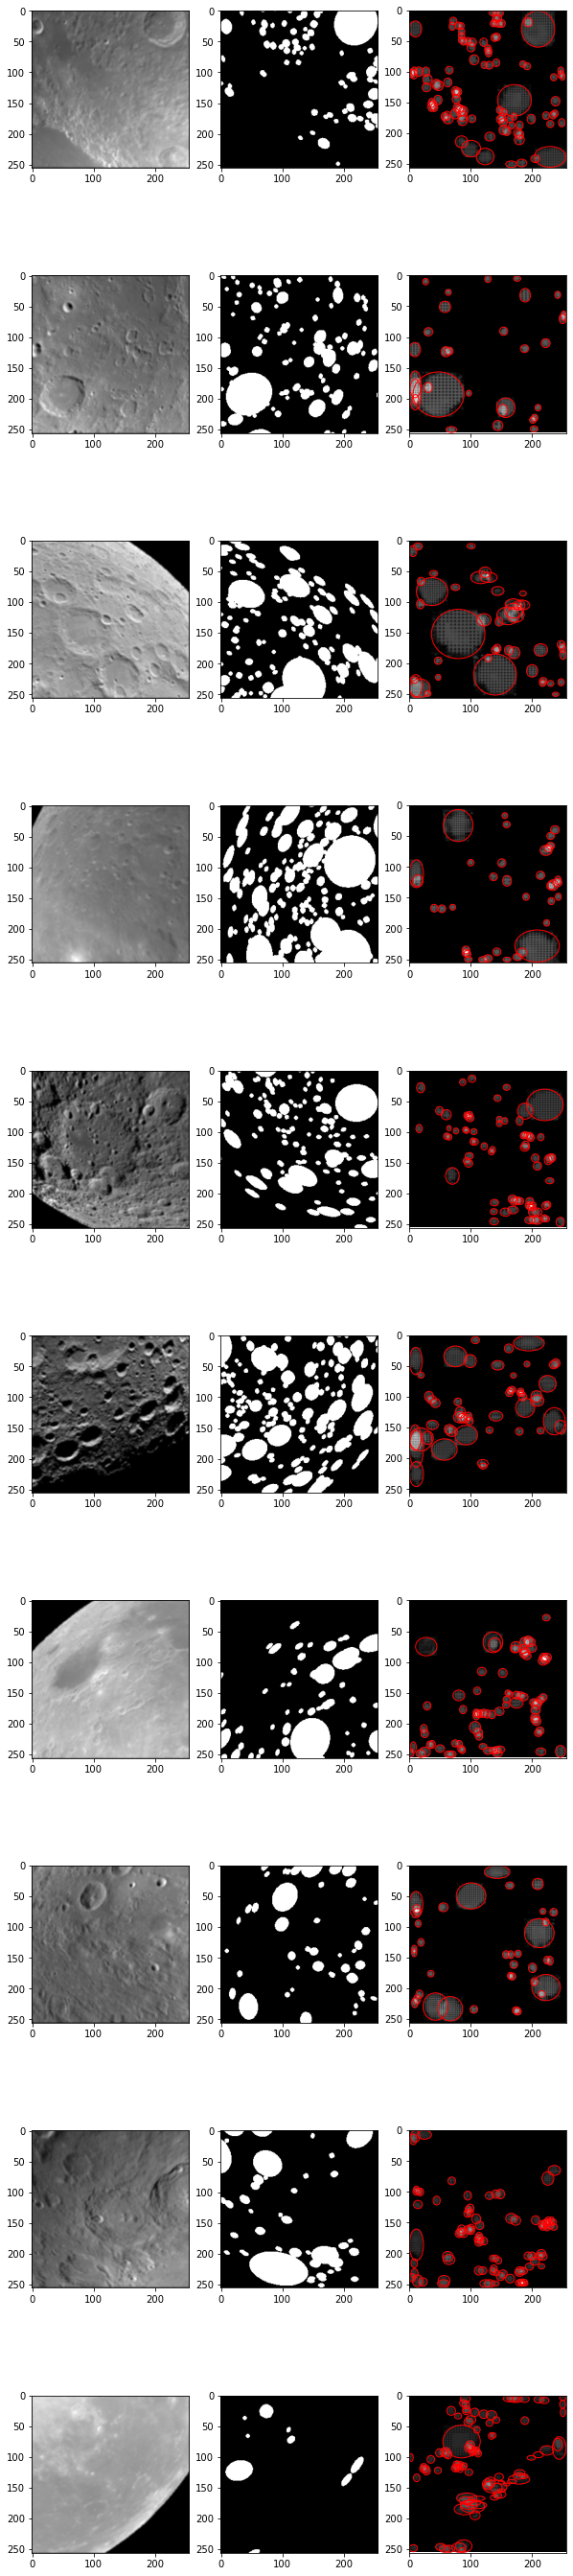

In [15]:
fig, axes = plt.subplots(len(out), 3, figsize=(10, len(out)*5))
for j in range(len(out)):
    test_masks = out[j]['masks']
    target_masks = targets[j]['masks']
    test_scores = out[j]['scores']
    test_masks = test_masks[test_scores > 0.5]
    for i in range(test_masks.shape[0]):
        cnt = np.array(np.where(test_masks[i, 0].numpy() > 0.0)).T[:, None, :]
        cnt[..., [0, 1]] = cnt[..., [1, 0]]
        (x, y), (a, b), psi = cv2.fitEllipse(cnt)
        psi = np.radians(psi)
        A = conic_matrix(a, b, psi, x, y)
        plot_conics(A, ax=axes[j, 2])

    axes[j, 0].imshow(images[j][0].numpy(), cmap='gray')
    axes[j, 1].imshow(np.sum(target_masks.numpy(), axis=0), cmap='gray')
    axes[j, 2].imshow(np.sum(test_masks.numpy(), axis=0)[0], cmap='gray')


In [16]:
model.train()
model(images, targets)

{'loss_classifier': tensor(0.6407, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.4030, grad_fn=<DivBackward0>),
 'loss_mask': tensor(1.0414, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_objectness': tensor(0.3919, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.5926, grad_fn=<DivBackward0>)}

In [17]:
generator = DataGenerator.from_robbins_dataset(file_path="../data/lunar_crater_database_robbins_2018.csv")

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [18]:
generator.set_random_position()
while generator.solar_incidence_angle < 30:
    generator.set_random_position()
image, mask = map(torch.as_tensor, generator.image_mask_pair())

mask: torch.Tensor = mask.int()

obj_ids = mask.unique()[1:]
masks = mask == obj_ids[:, None, None]
num_objs = len(obj_ids)

boxes = torch.zeros((num_objs, 4), dtype=torch.float32)

for i in range(num_objs):
    pos = torch.where(masks[i])
    xmin = pos[1].min()
    xmax = pos[1].max()
    ymin = pos[0].min()
    ymax = pos[0].max()
    boxes[i] = torch.tensor([xmin, ymin, xmax, ymax])

area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
area_filter = area > 4

masks, obj_ids, boxes, area = map(lambda x: x[area_filter], (masks, obj_ids, boxes, area))

num_objs = len(obj_ids)

labels = torch.ones((num_objs,), dtype=torch.int64)
masks = masks.int()
image_id = torch.tensor([0])

iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

target = dict(
    boxes=boxes,
    labels=labels,
    masks=masks,
    image_id=image_id,
    area=area,
    iscrowd=iscrowd
)

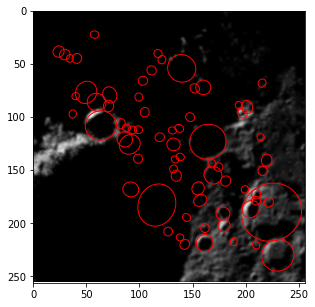

In [19]:
generator.plot(figsize=(5,5))
plt.imshow(generator.generate_image(), cmap='gray')

In [26]:
Q_proposals = torch.zeros((len(boxes), 3))

Q_proposals[:, 0] = boxes[:, 0] + (boxes[:, 2] - boxes[:, 0])/2
Q_proposals[:, 1] = boxes[:, 1] + (boxes[:, 3] - boxes[:, 1])/2
Q_proposals[:, 2] = torch.sqrt((boxes[:, 2] - boxes[:, 0])**2 + (boxes[:, 2] - boxes[:, 0])**2)
Q_proposals[:5]

tensor([[ 63.0000, 108.0000,  42.4264],
        [ 92.0000, 168.0000,  22.6274],
        [ 91.0000, 126.0000,  28.2843],
        [ 86.0000, 121.0000,  19.7990],
        [116.0000, 183.0000,  48.0833]])

In [21]:
A_craters = generator.craters_in_image()

x, y = conic_center(A_craters).T
a, b = ellipse_axes(A_craters)
angle = ellipse_angle(A_craters)

In [28]:
E_proposals = np.zeros((len(A_craters), 5))

E_proposals[:, 0] = x
E_proposals[:, 1] = y
E_proposals[:, 2] = a
E_proposals[:, 3] = b
E_proposals[:, 4] = angle
E_proposals = torch.as_tensor(E_proposals)
E_proposals[:5]

tensor([[ 6.3485e+01,  1.0787e+02,  2.9248e+01,  2.7581e+01, -1.1958e-01],
        [ 9.1789e+01,  1.6807e+02,  1.5127e+01,  1.3895e+01,  2.8492e-01],
        [ 9.0846e+01,  1.2564e+02,  2.0203e+01,  1.7893e+01, -5.4467e-01],
        [ 8.6165e+01,  1.2101e+02,  1.4760e+01,  1.4074e+01,  5.3812e-01],
        [ 1.1632e+02,  1.8278e+02,  4.0510e+01,  3.4964e+01, -1.1861e+00]],
       dtype=torch.float64)

In [23]:
d_x = (E_proposals[:, 0] - Q_proposals[:, 0])/Q_proposals[:, 2]
d_y = (E_proposals[:, 1] - Q_proposals[:, 1])/Q_proposals[:, 2]
d_a = torch.log(2*E_proposals[:, 2]/Q_proposals[:, 2])
d_b = torch.log(2*E_proposals[:, 3]/Q_proposals[:, 2])
d_angle = E_proposals[:, 4]/np.pi

In [32]:
d_x

tensor([ 0.0114, -0.0093, -0.0055,  0.0084,  0.0067, -0.0063,  0.0212,  0.0064,
        -0.0018,  0.0243,  0.0399, -0.0231, -0.0410, -0.0027, -0.0310,  0.0239,
        -0.0181,  0.0193,  0.0011, -0.0268,  0.0040, -0.0095,  0.0326, -0.0099,
         0.0010,  0.0360,  0.0047, -0.0255,  0.0013,  0.0295,  0.0168,  0.0107,
         0.0100, -0.0232,  0.0079,  0.0155,  0.0103,  0.0262,  0.0398, -0.0582,
         0.0156,  0.0396,  0.0344, -0.0121, -0.0208, -0.0081, -0.0250, -0.0008,
        -0.0133,  0.0025, -0.0251,  0.0037, -0.0338,  0.0222,  0.0280,  0.0096,
        -0.0161, -0.0144,  0.0154, -0.0581, -0.0288,  0.0002, -0.0292, -0.0061,
        -0.0014,  0.0370,  0.0064, -0.0242, -0.0276, -0.0171],
       dtype=torch.float64)